## Importing Libraries

In [2]:
# Data Handling and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objs as go

# Dash for Dashboard
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score, auc
)

# Deep Learning with TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Conv1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow import keras
from tensorflow.keras import layers

# Explainability Libraries
import shap
import lime
import lime.lime_text

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


C:\Users\vishn\anaconda3\envs\tf-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [3]:
data = pd.read_csv(r"C:\Users\vishn\Downloads\fake_and_real_news (1).csv")
data

Text label
0      Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake
1     U.S. conservative leader optimistic of common ...  Real
2     Trump proposes U.S. tax overhaul, stirs concer...  Real
3      Court Forces Ohio To Allow Millions Of Illega...  Fake
4     Democrats say Trump agrees to work on immigrat...  Real
...                                                 ...   ...
9895   Wikileaks Admits To Screwing Up IMMENSELY Wit...  Fake
9896  Trump consults Republican senators on Fed chie...  Real
9897  Trump lawyers say judge lacks jurisdiction for...  Real
9898   WATCH: Right-Wing Pastor Falsely Credits Trum...  Fake
9899   Sean Spicer HILARIOUSLY Branded As Chickensh*...  Fake

[9900 rows x 2 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    9900 non-null   object
 1   label   9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB


In [5]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Text     0
label    0
dtype: int64


In [6]:
# Display first few rows
print("\nSample Data:")
print(data.head())


Sample Data:
                                                Text label
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake
1  U.S. conservative leader optimistic of common ...  Real
2  Trump proposes U.S. tax overhaul, stirs concer...  Real
3   Court Forces Ohio To Allow Millions Of Illega...  Fake
4  Democrats say Trump agrees to work on immigrat...  Real


## Exploratary Data Analysis

Below code visualizes the distribution of different labels in a dataset using a bar plot. It helps identify class imbalance, which is important for training balanced machine learning models. The `sns.countplot` shows the count of each label, with custom styling for better readability.

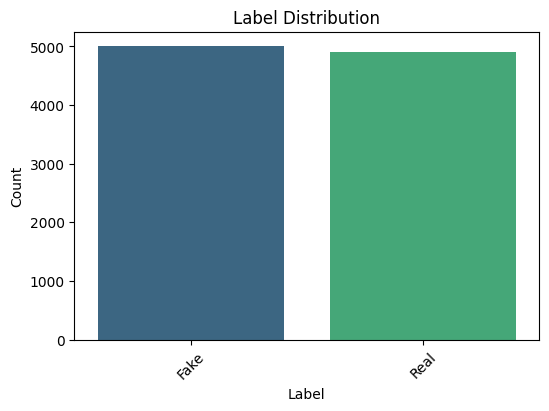

In [7]:
# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(data=data, x="label", palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Below code calculates the number of words in each text entry by splitting the text and measuring its length. It then creates a histogram to visualize the distribution of text lengths across the dataset, helping to understand the typical size and variability of the text data.

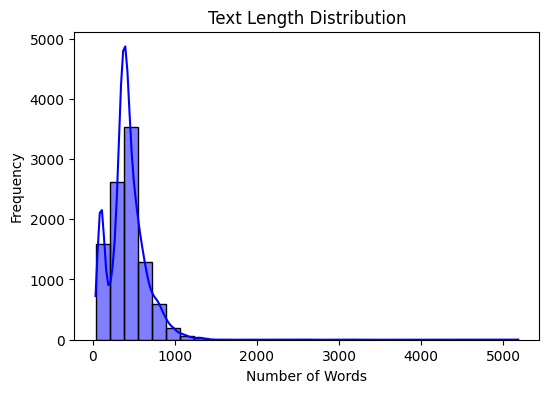

In [8]:
# Text length analysis
data["text_length"] = data["Text"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(data["text_length"], bins=30, kde=True, color="blue")
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

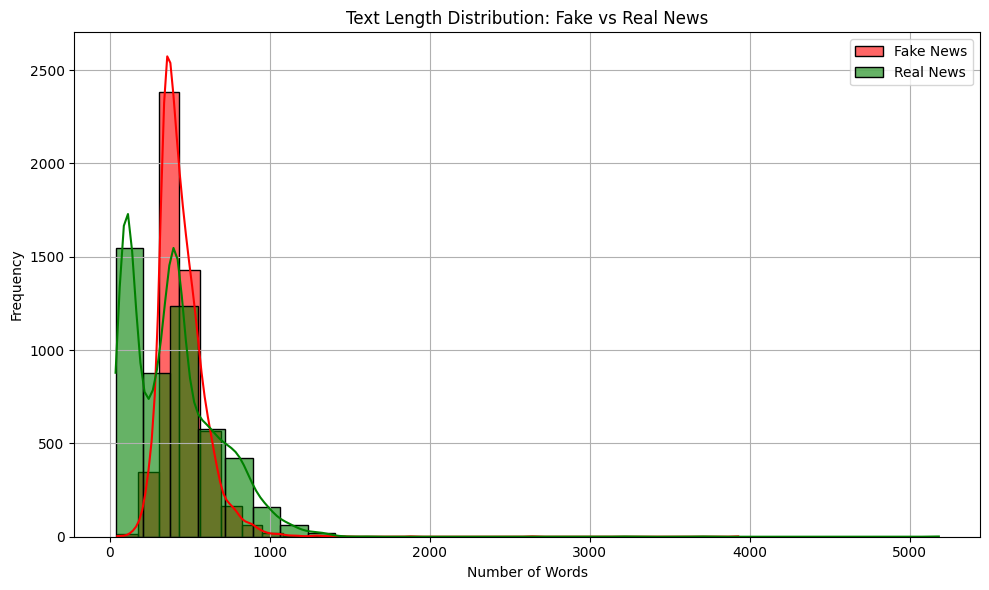

In [9]:
# Create two series for fake and real news
fake_lengths = data[data['label'] == 'Fake']['text_length']
real_lengths = data[data['label'] == 'Real']['text_length']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(fake_lengths, bins=30, color='red', label='Fake News', kde=True, alpha=0.6)
sns.histplot(real_lengths, bins=30, color='green', label='Real News', kde=True, alpha=0.6)

# Plot settings
plt.title('Text Length Distribution: Fake vs Real News')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This code generates and displays a separate word cloud for each unique label in the dataset, allowing for visual comparison of the most frequent words associated with each label. It helps in understanding the distinguishing language patterns or key terms within each labeled category.

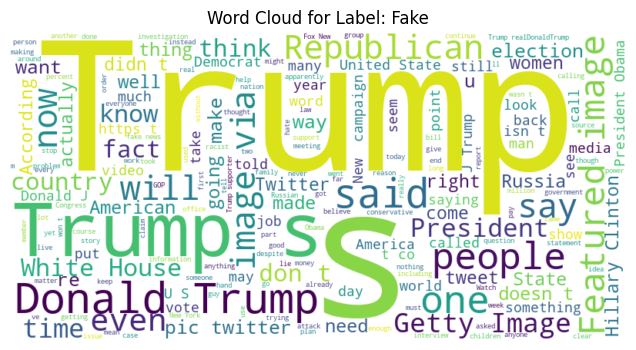

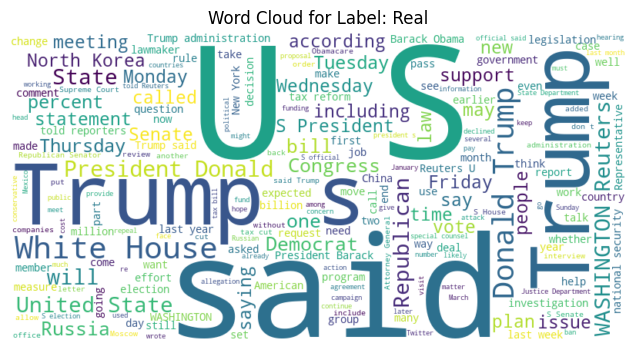

In [10]:
# Generate WordClouds for each label
labels = data["label"].unique()
for label in labels:
    text_data = " ".join(data[data["label"] == label]["Text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Label: {label}")
    plt.axis("off")
    plt.show()

## Preprocessing and Modelling

As size of dataset is quite large and pre-processing would require more time to complete the execution. So I have selected first 1000 rows of data.

In [11]:
# Select the first 1000 rows
df = data.head(1000)

# Display the selected rows
df

Text label  text_length
0     Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake          279
1    U.S. conservative leader optimistic of common ...  Real          116
2    Trump proposes U.S. tax overhaul, stirs concer...  Real          989
3     Court Forces Ohio To Allow Millions Of Illega...  Fake          364
4    Democrats say Trump agrees to work on immigrat...  Real          594
..                                                 ...   ...          ...
995  Judge tells ex-Trump adviser Manafort to stop ...  Real          515
996   CAN’T-MISS: Bernie And Hillary MOP The FLOOR ...  Fake          535
997  Vice President Pence urges Congress to complet...  Real          360
998   WATCH: Justin Trudeau Has The PERFECT Respons...  Fake          333
999  Trump, his party: an American odd couple WASHI...  Real          675

[1000 rows x 3 columns]

In [12]:
df1 = df.copy()

### Constructing the text classification model, which can recognize fake news from original news.

Below code selects the features and labels from a DataFrame `df` for a machine learning task. `X = df['Text']` extracts the input text data, while `y = df['label']` gets the corresponding target labels used for training or evaluation.

In [13]:
# Data Preprocessing
X = df['Text']
y = df['label']

This code splits the dataset into training and test sets, with 70% used for training and 30% for testing. The `stratify=y` ensures that the class distribution in `y` is preserved in both sets, and `random_state=42` ensures reproducibility of the split.

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

This code converts text data into numerical feature vectors using the TF-IDF (Term Frequency-Inverse Document Frequency) method. It removes common English stop words, ignores very frequent (`max_df=0.95`) and very rare (`min_df=5`) terms, and transforms both training and test datasets into TF-IDF representations for use in machine learning models.

In [15]:
# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Logistic Regression

This code initializes a logistic regression model with a maximum of 1000 iterations and trains it using the TF-IDF-transformed training data (`X_train_tfidf`) and corresponding labels (`y_train`). Training allows the model to learn patterns in the data to make predictions on new, unseen text.

In [16]:
# Initialize and Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

This code generates predictions for the test data using a trained machine learning model. The `model.predict(X_test_tfidf)` function applies the model to the TF-IDF-transformed test features (`X_test_tfidf`), and stores the predicted labels in `y_pred_lr`. This is necessary to evaluate the model’s performance on unseen data.

In [17]:
# Make Predictions
y_pred_lr = model.predict(X_test_tfidf)

This code evaluates the performance of a machine learning model (likely logistic regression, as hinted by `y_pred_lr`) by printing three key metrics: accuracy score, a detailed classification report (precision, recall, F1-score), and a confusion matrix. These help assess how well the model predicts the test data (`y_test`) compared to its actual labels.

In [18]:
# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

        Fake       0.97      0.96      0.97       151
        Real       0.96      0.97      0.97       149

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

Confusion Matrix:
 [[145   6]
 [  4 145]]


This code generates a **confusion matrix heatmap** to visually evaluate the performance of a logistic regression model. It shows how well the model predicted each class by comparing actual vs. predicted labels, helping identify misclassifications.

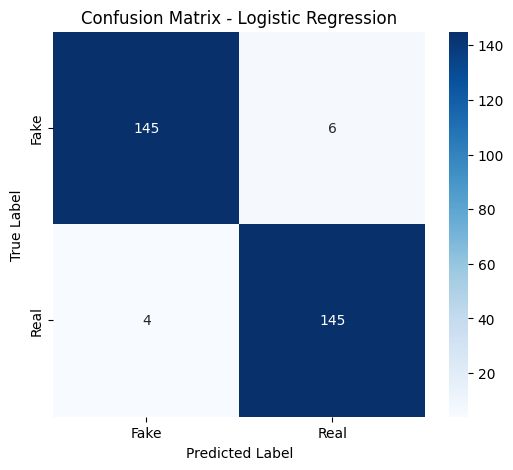

In [19]:
# --- Confusion Matrix Plot ---
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

This code evaluates the performance of a classification model by plotting the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between true positive and false positive rates at various thresholds. It uses predicted probabilities for the positive class (e.g., 'Real') to compute the curve and the Area Under the Curve (AUC) score, indicating how well the model distinguishes between classes.

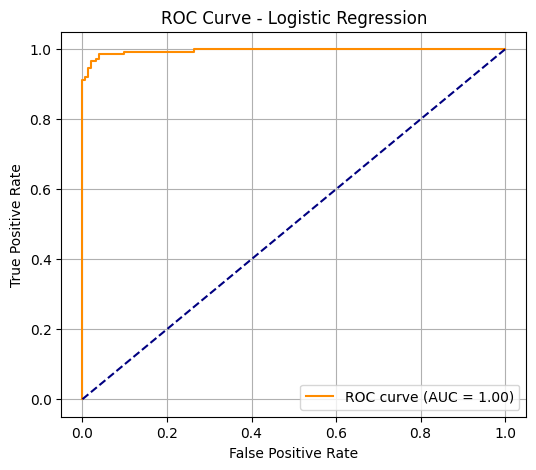

In [20]:
# Get predicted probabilities for the positive class (e.g., 'Real')
y_scores = model.predict_proba(X_test_tfidf)[:, 1]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='Real')
auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Random Forest

This code initializes a Random Forest Classifier with 100 decision trees and a fixed random state for reproducibility. It then trains (fits) the model on the TF-IDF-transformed training data (`X_train_tfidf`) and corresponding labels (`y_train`) to learn patterns for classification.

In [21]:
# Initialize and Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

This code generates predictions using the trained Random Forest model (`rf_model`) on the test data (`X_test_tfidf`). It's necessary to evaluate how well the model performs on unseen data by comparing these predictions (`y_pred_rf`) to the actual test labels.

In [22]:
# Make Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

This code evaluates the performance of a Random Forest classifier. It prints the model's **accuracy**, a **detailed classification report** (including precision, recall, and F1-score), and the **confusion matrix** to show how well the model predicted each class. These metrics help assess the model’s effectiveness.

In [23]:
# Evaluate the Model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       151
        Real       1.00      1.00      1.00       149

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Random Forest Confusion Matrix:
 [[151   0]
 [  0 149]]


This code generates a **confusion matrix heatmap** to visually evaluate the performance of a Random Forest classifier (`y_pred_rf`) by comparing predicted vs actual labels (`y_test`). It helps identify how well the model distinguishes between the "Fake" and "Real" classes, showing correct and incorrect predictions.

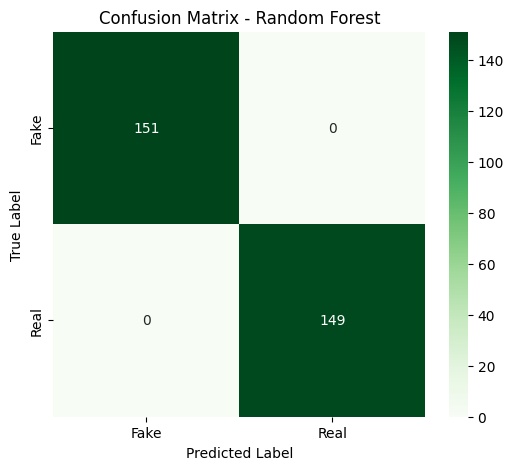

In [24]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

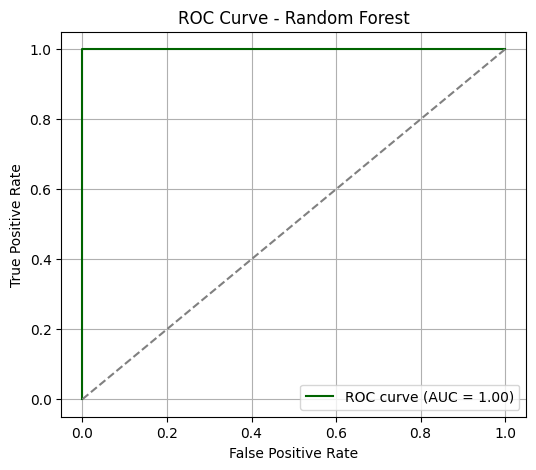

In [25]:
# Get predicted probabilities for the positive class (e.g., 'Real')
y_scores_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC score
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf, pos_label='Real')
auc_score_rf = roc_auc_score(y_test, y_scores_rf)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, color='darkgreen', label=f'ROC curve (AUC = {auc_score_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### SVM

In [26]:
# Initialize and Train SVM Model
svm_model = SVC(kernel='linear')  # You can try 'rbf', 'poly', etc.
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [27]:
# Make Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

In [28]:
# Evaluate the Model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM Accuracy: 0.9733333333333334
SVM Classification Report:
               precision    recall  f1-score   support

        Fake       0.98      0.97      0.97       151
        Real       0.97      0.98      0.97       149

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

SVM Confusion Matrix:
 [[146   5]
 [  3 146]]


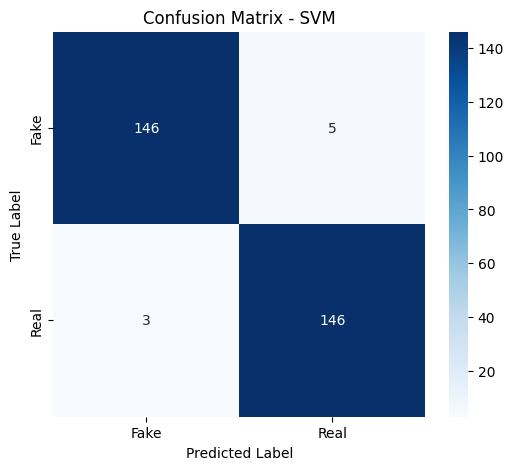

In [29]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

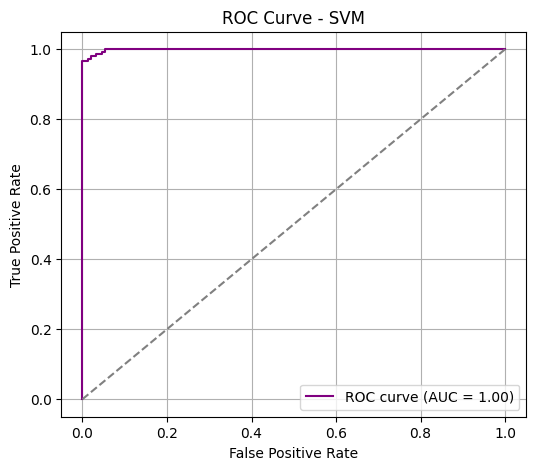

In [30]:
svm_model_prob = SVC(kernel='linear', probability=True, random_state=42)
svm_model_prob.fit(X_train_tfidf, y_train)

# Get predicted probabilities for the positive class (e.g., 'Real')
y_scores_svm = svm_model_prob.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC score
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm, pos_label='Real')
auc_score_svm = roc_auc_score(y_test, y_scores_svm)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, color='purple', label=f'ROC curve (AUC = {auc_score_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### LSTM

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         1000 non-null   object
 1   label        1000 non-null   object
 2   text_length  1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


This code builds and trains an LSTM-based deep learning model to classify text data. It includes preprocessing steps like tokenization, padding, and label encoding, then defines and trains a sequential model using embedding and LSTM layers for binary classification. Finally, it evaluates the model's accuracy on a test set.

In [32]:
# Load data
texts = df1['Text'].values
labels = df1['label'].values

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization
vocab_size = 5000  # Adjust as needed
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = df1['text_length'].max()
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Build LSTM model
embedding_dim = 64
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Change activation based on classification type
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 216s 16s/step - accuracy: 0.4806 - loss: 0.6942 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 214s 17s/step - accuracy: 0.5020 - loss: 0.6936 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 227s 18s/step - accuracy: 0.5098 - loss: 0.6940 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 221s 17s/step - accuracy: 0.5053 - loss: 0.6936 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 232s 18s/step - accuracy: 0.4764 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6934
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 231s 18s/step - accuracy: 0.4956 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6935
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 236s 18s/step - accuracy: 0.5076 - loss: 0.6930 - val_accuracy: 0.4900 - val_loss: 0.6936
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 230s 18s/step - accuracy: 0.4406 - loss: 0.6945 - val_accuracy: 0.

### Deep Learning Model for Text Classification

This code prepares text data for binary classification using a deep learning model. It encodes labels, tokenizes and pads text inputs, defines a neural network with an embedding layer, and trains it to predict class labels. The model is then evaluated for accuracy on test data.

In [33]:
# Step 1: Prepare data
X = df1['Text'].values
y = df1['label'].values

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Step 2: Tokenization and Padding
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Step 3: Define the Deep Learning Model
TextClassifierDL = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Step 4: Compile the Model
TextClassifierDL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 5: Train the Model
history = TextClassifierDL.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

# Step 6: Evaluate the Model
loss, accuracy = TextClassifierDL.evaluate(X_test_pad, y_test)
print(f"Deep Learning Model Accuracy: {accuracy:.2f}")

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7508 - loss: 0.6831 - val_accuracy: 0.9933 - val_loss: 0.6105
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9956 - loss: 0.5585 - val_accuracy: 1.0000 - val_loss: 0.3346
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9966 - loss: 0.2561 - val_accuracy: 0.9967 - val_loss: 0.0829
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9970 - loss: 0.0511 - val_accuracy: 0.9967 - val_loss: 0.0297
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9967 - val_loss: 0.0120
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


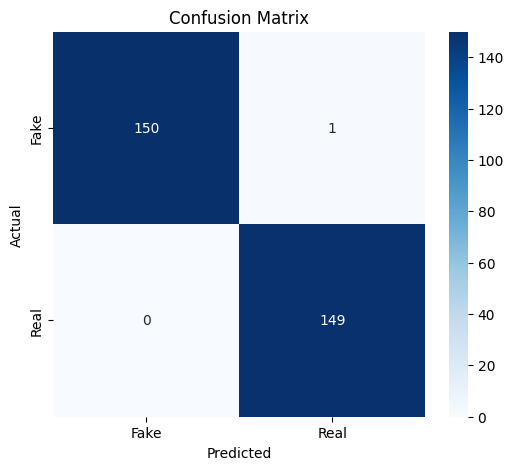

In [34]:
# Step 1: Get predictions (probabilities and labels)
y_probs = TextClassifierDL.predict(X_test_pad).ravel()  # Probabilities
y_pred = (y_probs >= 0.5).astype(int)                   # Convert to binary predictions

# Step 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

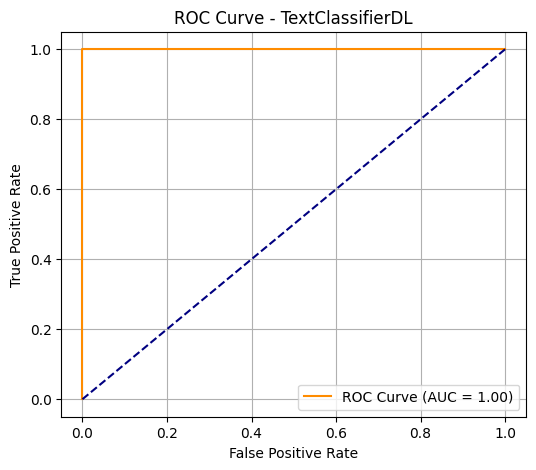

In [35]:
# Step 3: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TextClassifierDL')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### CNN

This code defines, compiles, trains, and evaluates a Convolutional Neural Network (CNN) for binary text classification. It uses word embeddings and convolutional layers to extract features from text data and predict binary labels (e.g., spam vs. not spam). The model is trained on padded input sequences and evaluated on test data for accuracy.

In [36]:
# Define CNN Model
TextClassifierCNN = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Conv1D(128, 5, activation='relu'),  # 128 filters, kernel size 5
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the Model
TextClassifierCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model
history_cnn = TextClassifierCNN.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test)
)

# Evaluate the Model
loss_cnn, acc_cnn = TextClassifierCNN.evaluate(X_test_pad, y_test)
print(f"CNN Model Accuracy: {acc_cnn:.2f}")

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5433 - loss: 0.6840 - val_accuracy: 0.9900 - val_loss: 0.5789
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9775 - loss: 0.4912 - val_accuracy: 0.9900 - val_loss: 0.2018
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9874 - loss: 0.1611 - val_accuracy: 0.9900 - val_loss: 0.0477
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9967 - loss: 0.0313 - val_accuracy: 0.9900 - val_loss: 0.0387
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9971 - loss: 0.0156 - val_accuracy: 0.9900 - val_loss: 0.0362
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9900 - val_loss: 0.0392
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9947 - loss: 0.0080 - val_accuracy: 0.9900 - val_loss: 0.0409
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9900 - v

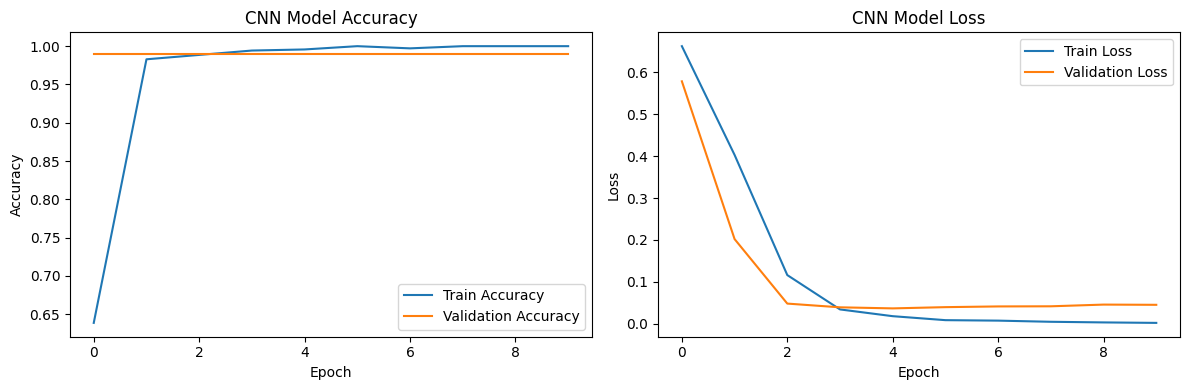

In [37]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## LIME

This code builds a text classification pipeline using TF-IDF and Logistic Regression, trains it on labeled text data, and uses LIME to generate interpretable explanations for model predictions. It helps understand which words in a sample text most influence the predicted class.

### LIME with logistic Regression

In [39]:
# Encode labels
le = LabelEncoder()
df1['label'] = le.fit_transform(df1['label'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df1['Text'], df1['label'], test_size=0.2, random_state=42)

# Create a pipeline with TF-IDF and Logistic Regression
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()
model = make_pipeline(vectorizer, classifier)

# Train the model
model.fit(X_train, y_train)

# LIME Explanation
explainer = lime.lime_text.LimeTextExplainer(class_names=le.classes_)
def explain_instance_lime(text_instance):
    exp = explainer.explain_instance(text_instance, model.predict_proba, num_features=10)
    exp.show_in_notebook(text=True)
    return exp


# Test explanations
sample_text = X_test.iloc[1]
print("LIME Explanation:")
lime_exp = explain_instance_lime(sample_text)

LIME Explanation:


### LIME With CNN

In [41]:
from lime.lime_text import LimeTextExplainer

# Encode labels and split
le = LabelEncoder()
df1['label_enc'] = le.fit_transform(df1['label'])
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df1['Text'], df1['label_enc'], test_size=0.2, random_state=42, stratify=df1['label_enc']
)

# Tokenize & pad
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_length, padding='post', truncating='post')

# Build & train your CNN
cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Wrap CNN for LIME’s predict_proba interface
def cnn_predict_proba(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    pads = pad_sequences(seqs, maxlen=max_length, padding='post', truncating='post')
    proba_real = cnn.predict(pads).flatten()            
    proba_fake = 1 - proba_real                         
    return np.vstack([proba_fake, proba_real]).T        

# Create the explainer
explainer = LimeTextExplainer(class_names=le.classes_)

#  Explain one sample
sample_text = X_test_text.iloc[4]
exp = explainer.explain_instance(sample_text, cnn_predict_proba, num_features=10)

# Display in notebook
print("Original text:\n", sample_text, "\n")
print("LIME explanation (feature: weight):")
for feature, weight in exp.as_list():
    print(f"  {feature:20s}: {weight:+.4f}")


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5162 - loss: 0.6884 - val_accuracy: 0.9450 - val_loss: 0.6173
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8892 - loss: 0.5296 - val_accuracy: 0.9800 - val_loss: 0.2080
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9908 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9972 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9996 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0021
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
Original text:
 Trump invites leaders of Thailand, Singapore to the White House WASHINGTON (Reuters) - U.S. President Donald Trump spoke to the leaders of Thailand and Singapore on Sunday in separate phone calls about the security situation in the Asia-Pacific region at a time of rising tensions with North Korea and invited b

In [42]:
from IPython.core.display import display, HTML

exp = explainer.explain_instance(sample_text, model.predict_proba, num_features=10)

#Grab the HTML
html = exp.as_html()

display(HTML(html))

In [43]:
df['label'] = df['label'].astype(str).str.strip().str.upper().apply(lambda x: 1 if x == 'REAL' else 0)
print(df['label'].value_counts())  
print(df['label'].unique())

label
0    502
1    498
Name: count, dtype: int64
[0 1]


## GRAPHICAL USER INTERFACE (GUI)

In [ ]:
%gui tk
import tkinter as tk
from tkinter import messagebox, scrolledtext, Toplevel
import numpy as np
from lime.lime_text import LimeTextExplainer


explainer = LimeTextExplainer(class_names=["Fake", "Real"])

def predict_proba_fn(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    pads = pad_sequences(seqs, maxlen=max_length, padding="post", truncating="post")
    p_real = TextClassifierCNN.predict(pads).flatten()
    p_fake = 1 - p_real
    return np.vstack([p_fake, p_real]).T

def classify_with_cnn():
    raw = entry.get("1.0", "end-1c").strip()
    if not raw:
        messagebox.showwarning("Input Error", "Please enter some news text!")
        return

    seq = tokenizer.texts_to_sequences([raw])
    pad  = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")
    p_real = float(TextClassifierCNN.predict(pad)[0,0])
    label = "Real" if p_real >= 0.5 else "Fake"
    color = "green" if label == "Real" else "red"

    percent = p_real * 100
    result_label.config(
        text=f"Prediction: {label}  ({percent:.1f}%)",
        fg=color
    )

    classify_with_cnn.last_input = raw

def explain_with_lime():
    raw = getattr(classify_with_cnn, "last_input", "").strip()
    if not raw:
        messagebox.showwarning("No Prediction", "Classify some text first!")
        return

    exp = explainer.explain_instance(raw, predict_proba_fn, num_features=10)

    win = Toplevel(root)
    win.title("LIME Explanation")
    txt = scrolledtext.ScrolledText(win, width=60, height=20, font=("Courier",10))
    txt.pack(padx=10, pady=10)
    for feature, weight in exp.as_list():
        txt.insert(tk.END, f"{feature:20s} : {weight:+.4f}\n")
    txt.configure(state="disabled")

root = tk.Tk()
root.title("Fake News Detector (CNN + LIME)")
root.geometry("600x500")

tk.Label(root, text="Enter News Text:", font=("Arial", 14)).pack(pady=10)
entry = tk.Text(root, height=10, width=70, font=("Arial", 12))
entry.pack(padx=10, pady=5)

btn_frame = tk.Frame(root)
btn_frame.pack(pady=10)
tk.Button(btn_frame, text="Classify News", font=("Arial",12),
          command=classify_with_cnn).grid(row=0, column=0, padx=5)
tk.Button(btn_frame, text="Explain (LIME)", font=("Arial",12),
          command=explain_with_lime).grid(row=0, column=1, padx=5)

result_label = tk.Label(root, text="Prediction: ", font=("Arial", 14))
result_label.pack(pady=20)

root.mainloop()